In [2]:
"""
The code for testing the classifiers. Uses binary.csv and multiclass.csv

Loads feature lists and tuning ranges from pickles in CWD.

Change model types in models to tune on specific ones.

Writes output files.

TODO: more scoring metrics (maybe?), additional classifiers (maybe another flavour of SVM?)


Author: Wesley
"""

# Accelerates tuning of some classifiers
#from sklearnex import patch_sklearn
#patch_sklearn()

import pandas as pd
import numpy as np

from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

from sklearn.feature_selection import RFECV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    accuracy_score
)

from time import time

from sklearn.metrics import classification_report

In [3]:
binary = pd.read_csv("binary.csv")
multiclass = pd.read_csv("multiclass.csv")

Preprocessing (make labels numeric)

In [4]:
# Binarize binary dataset.
binary[" Label"] = binary[" Label"].apply(lambda x: 0 if x == "BENIGN" else 1)

print("The text labels from the encoding will be passed to classification report so we can interpret our results more easily.\n")
binary_labels = ["BENIGN", "ATTACK"]

print("Binary Label Encodings (in order of digits 0 -> 1): ")
print(binary_labels)

# Encode attack labels to int and save as array to be used later.
le = LabelEncoder()
multiclass[" Label"] = le.fit_transform(multiclass[" Label"].values)

multiclass_labels = []
print("\nMulticlass Label Encodings (in order of digits 0 -> n): ")
for i in range(0, len(list(set(list(multiclass[' Label']))))):
    multiclass_labels.append(le.inverse_transform([i])[0])

print(multiclass_labels)

The text labels from the encoding will be passed to classification report so we can interpret our results more easily.

Binary Label Encodings (in order of digits 0 -> 1): 
['BENIGN', 'ATTACK']

Multiclass Label Encodings (in order of digits 0 -> n): 
['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


Load feature sets and search spaces and enumerate their contents.

In [5]:
feature_sets = pickle.load(open("feature_sets.pickle", 'rb'))
search_spaces = pickle.load(open("hyperparameter_search_spaces.pickle", 'rb'))

print(f"Available Tuning Ranges: {search_spaces.keys()}")

print("Feature Sets for Binary Dataset:")
for key, value in feature_sets["Binary"].items():
    if key == "RFE Sets":
        print(value.keys())

    elif key == "PCA":
        print(f"{key}, suggested variance threshold is {value}")
        
    else:
        print(key)

print("Feature Sets for Multiclass Dataset:")
for key, value in feature_sets["Multiclass"].items():
    if key == "RFE Sets":
        print(value.keys())

    elif key == "PCA":
        print(f"{key}, suggested variance threshold is {value}")

    else:
        print(key)

Available Tuning Ranges: dict_keys(['XGBoost', 'Bagging SVM', 'SVC (RBF)', 'SVC (Poly)', 'Logistic Regression', 'Random Forest', 'KNN', 'Linear SVC', 'Naive Bayes', 'Decision Tree'])
Feature Sets for Binary Dataset:
All
Correlation
Mutual Information
dict_keys(['Decision Tree', 'Random Forest', 'XGBoost', 'Linear SVC', 'Logistic Regression'])
PCA, suggested variance threshold is 0.95
Feature Sets for Multiclass Dataset:
All
Correlation
Mutual Information
dict_keys(['Decision Tree', 'Random Forest', 'XGBoost', 'Logistic Regression'])
PCA, suggested variance threshold is 0.95


In [6]:
"""
This is a helper method to place our performance results in a DataFrame for future analysis.
"""
def format_results(y_test, predicted_values, fold_index, fitTime):
    # get scores
    accuracy = accuracy_score(y_test,predicted_values)
    recall_pos = recall_score(y_test, predicted_values)
    precision_pos = precision_score(y_test,predicted_values)
    f1 = f1_score(y_test,predicted_values)
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_values).ravel()

    # This avoids divide by zero errors in some cases of no predicted samples.
    if (tn + fp) > 0:
        recall_neg = tn / (tn + fp)
    else:
        recall_neg = 0

    if (tn + fn) > 0:
        precision_neg = tn / (tn + fn)
    else:
        precision_neg = 0

    cols = ["Fitting Time", "accuracy", "TP", "TN", "FP", "FN", "Precision: 0", "Precision: 1", "Recall: 0", "Recall: 1", "F1 Score"]
    results = [fitTime, accuracy, tp, tn, fp, fn, precision_neg, precision_pos, recall_neg, recall_pos, f1]

    outFrame = pd.DataFrame([results], columns=cols, index=[fold_index])

    return outFrame

In [7]:
"""
This is a helper method to place our performance results in a DataFrame for future analysis.
"""
def format_results_multiclass(y_test, predicted_values, fold_index, fitTime):
    # get scores
    accuracy = accuracy_score(y_test,predicted_values)
    recall_pos = recall_score(y_test, predicted_values, average='macro')
    precision_pos = precision_score(y_test,predicted_values, average='macro')
    f1 = f1_score(y_test,predicted_values, average='macro')

    cols = ["Fitting Time", "accuracy", "Precision", "Recall", "F1 Score"]
    results = [fitTime, accuracy, precision_pos, recall_pos, f1]

    outFrame = pd.DataFrame([results], columns=cols, index=[fold_index])

    return outFrame

This is for tuning on the Binary set.

In [8]:
models = {
    #"Decision Tree": DecisionTreeClassifier(random_state=42),
    #"Random Forest": RandomForestClassifier(random_state=42),
    #"XGBoost": xgb.XGBClassifier(random_state=42),
    #"Linear SVC": make_pipeline(StandardScaler(), LinearSVC(random_state=42)),
    #"Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
}

score_methods = ['accuracy']

feature_set = feature_sets["Binary"]

y = binary[" Label"].copy()
X = binary.drop([" Label"], axis=1)

In [8]:
params = []
estimators = []

# This will hold all of our results.
runFrame = None

for name, model in models.items():
        for feature_key, feature_val in feature_set.items():

            # If we're on the RFE sets, check if we have one for this classifier. If not, skip it.
            if feature_key == "RFE Sets":
                if name in feature_val.keys():
                    feature_val = feature_val[name]
                else:
                    continue
            
            for score_method in score_methods:
                opt = BayesSearchCV(estimator=model,search_spaces=search_spaces[name],n_iter=30,scoring=score_method,cv=5,n_jobs=5)
                kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

                counter = 0

                # Used to hold data for a single run (performance metric)
                perfFrame = None

                for train_index, test_index in kf.split(X, y):

                    counter += 1

                    # PCA requires different logic to create X.
                    if feature_key != "PCA":
                        current_X = X.loc[:, feature_val]
                        X_train, X_test = current_X.iloc[train_index,:], current_X.iloc[test_index,:]
                        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
                        
                    else:
                        pca_trans = PCA(n_components=feature_val, random_state=42)
                        current_X = X.loc[:, X.columns]
                        X_train, X_test = current_X.iloc[train_index,:], current_X.iloc[test_index,:]
                        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]

                        # Apply PCA to training set and use it to transform test set.
                        X_train = pca_trans.fit_transform(X_train)
                        X_test = pca_trans.transform(X_test)

                        # Convert back to DataFrames
                        pca_cols = ["PC"+str(i) for i in list(range(1, len(X_train[0])+1))]
                        X_train = pd.DataFrame(data=X_train, columns=pca_cols)
                        X_test = pd.DataFrame(data=X_test, columns=pca_cols)

                    startTime = time()

                    opt.fit(X_train,Y_train)

                    endTime = time()
                    fitTime = endTime - startTime

                    predicted_values = opt.predict(X_test)

                    # get metrics for this fold.
                    foldFrame = format_results(Y_test, predicted_values, counter, fitTime)

                    # Add them to our lists of metric.
                    if perfFrame is None:
                        perfFrame = foldFrame
                    else:
                        perfFrame = pd.concat([perfFrame, foldFrame])

                    # Print a classification report as well.
                    print(classification_report(Y_test, predicted_values, target_names=binary_labels, digits=6))

                    # Add tuple with the best params as well as the related model/config
                    params.append((f"Binary {name} {feature_key} {score_method} Fold {counter}", opt.best_params_))
                    estimators.append((f"Binary {name} {feature_key} {score_method} Fold {counter}", opt.best_estimator_))

                # Create a new line in the results table that averages all the folds
                perfFrame.loc["fold average"] = perfFrame.mean()

                # Mark the results table with the chosen classifier and the current performance metric.
                perfFrame['metric'] = [score_method for j in range(0,6)]
                perfFrame['Classifier'] = [name for j in range(0,6)]
                perfFrame['Feature Set'] = [feature_key for j in range(0,6)]
                perfFrame['Dataset'] = ["binary" for j in range(0,6)]
                print(f"{name} with {feature_key} and {score_method} completed.")

                # Add this run to the table with all runs.
                if runFrame is None:
                    runFrame = perfFrame
                else:
                    runFrame = pd.concat([runFrame, perfFrame])

# Write output file and list of best estimators and parameters to be used later.
runFrame.to_csv(f"binary_results{time()}.csv")
pickle.dump(params, open(f"binary_params{time()}.pickle", "wb"))
pickle.dump(estimators, open(f"binary_estimators{time()}.pickle", "wb"))

c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.997149  0.993220  0.995181     10915
      ATTACK   0.993246  0.997160  0.995199     10914

    accuracy                       0.995190     21829
   macro avg   0.995197  0.995190  0.995190     21829
weighted avg   0.995198  0.995190  0.995190     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.996690  0.993311  0.994998     10914
      ATTACK   0.993335  0.996702  0.995015     10915

    accuracy                       0.995007     21829
   macro avg   0.995012  0.995007  0.995007     21829
weighted avg   0.995012  0.995007  0.995007     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.997155  0.995419  0.996286     10914
      ATTACK   0.995427  0.997160  0.996292     10914

    accuracy                       0.996289     21828
   macro avg   0.996291  0.996289  0.996289     21828
weighted avg   0.996291  0.996289  0.996289     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

      BENIGN   0.997059  0.994044  0.995549     10914
      ATTACK   0.994062  0.997068  0.995563     10914

    accuracy                       0.995556     21828
   macro avg   0.995561  0.995556  0.995556     21828
weighted avg   0.995561  0.995556  0.995556     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.996332  0.995419  0.995875     10914
      ATTACK   0.995423  0.996335  0.995879     10914

    accuracy                       0.995877     21828
   macro avg   0.995877  0.995877  0.995877     21828
weighted avg   0.995877  0.995877  0.995877     21828

KNN with All and accuracy completed.


c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.991197  0.990289  0.990742     10915
      ATTACK   0.990297  0.991204  0.990750     10914

    accuracy                       0.990746     21829
   macro avg   0.990747  0.990746  0.990746     21829
weighted avg   0.990747  0.990746  0.990746     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.991357  0.987905  0.989628     10914
      ATTACK   0.987949  0.991388  0.989665     10915

    accuracy                       0.989647     21829
   macro avg   0.989653  0.989647  0.989647     21829
weighted avg   0.989653  0.989647  0.989647     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.992029  0.992029  0.992029     10914
      ATTACK   0.992029  0.992029  0.992029     10914

    accuracy                       0.992029     21828
   macro avg   0.992029  0.992029  0.992029     21828
weighted avg   0.992029  0.992029  0.992029     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.991738  0.989830  0.990783     10914
      ATTACK   0.989849  0.991754  0.990800     10914

    accuracy                       0.990792     21828
   macro avg   0.990793  0.990792  0.990792     21828
weighted avg   0.990793  0.990792  0.990792     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.991107  0.990563  0.990835     10914
      ATTACK   0.990568  0.991112  0.990840     10914

    accuracy                       0.990837     21828
   macro avg   0.990838  0.990837  0.990837     21828
weighted avg   0.990838  0.990837  0.990837     21828

KNN with Correlation and accuracy completed.


c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.996782  0.993312  0.995044     10915
      ATTACK   0.993335  0.996793  0.995061     10914

    accuracy                       0.995052     21829
   macro avg   0.995058  0.995053  0.995052     21829
weighted avg   0.995058  0.995052  0.995052     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

      BENIGN   0.996598  0.993128  0.994860     10914
      ATTACK   0.993153  0.996610  0.994878     10915

    accuracy                       0.994869     21829
   macro avg   0.994875  0.994869  0.994869     21829
weighted avg   0.994875  0.994869  0.994869     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

      BENIGN   0.996881  0.995785  0.996333     10914
      ATTACK   0.995790  0.996885  0.996337     10914

    accuracy                       0.996335     21828
   macro avg   0.996336  0.996335  0.996335     21828
weighted avg   0.996336  0.996335  0.996335     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

      BENIGN   0.996327  0.994136  0.995230     10914
      ATTACK   0.994149  0.996335  0.995241     10914

    accuracy                       0.995235     21828
   macro avg   0.995238  0.995235  0.995235     21828
weighted avg   0.995238  0.995235  0.995235     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.995965  0.995144  0.995554     10914
      ATTACK   0.995148  0.995968  0.995558     10914

    accuracy                       0.995556     21828
   macro avg   0.995557  0.995556  0.995556     21828
weighted avg   0.995557  0.995556  0.995556     21828

KNN with Mutual Information and accuracy completed.
              precision    recall  f1-score   support

      BENIGN   0.971608  0.978195  0.974890     10915
      ATTACK   0.978044  0.971413  0.974717     10914

    accuracy                       0.974804     21829
   macro avg   0.974826  0.974804  0.974804     21829
weighted avg   0.974826  0.974804  0.974804     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

      BENIGN   0.971320  0.980575  0.975926     10914
      ATTACK   0.980390  0.971049  0.975697     10915

    accuracy                       0.975812     21829
   macro avg   0.975855  0.975812  0.975811     21829
weighted avg   0.975855  0.975812  0.975811     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

      BENIGN   0.969274  0.979842  0.974530     10914
      ATTACK   0.979620  0.968939  0.974250     10914

    accuracy                       0.974391     21828
   macro avg   0.974447  0.974391  0.974390     21828
weighted avg   0.974447  0.974391  0.974390     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.970178  0.980667  0.975394     10914
      ATTACK   0.980456  0.969855  0.975127     10914

    accuracy                       0.975261     21828
   macro avg   0.975317  0.975261  0.975260     21828
weighted avg   0.975317  0.975261  0.975260     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

      BENIGN   0.967970  0.980209  0.974051     10914
      ATTACK   0.979955  0.967565  0.973721     10914

    accuracy                       0.973887     21828
   macro avg   0.973963  0.973887  0.973886     21828
weighted avg   0.973963  0.973887  0.973886     21828

KNN with PCA and accuracy completed.


c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.866513  0.171874  0.286850     10915
      ATTACK   0.540328  0.973520  0.694944     10914

    accuracy                       0.572679     21829
   macro avg   0.703420  0.572697  0.490897     21829
weighted avg   0.703428  0.572679  0.490888     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.853635  0.162452  0.272958     10914
      ATTACK   0.537211  0.972148  0.692014     10915

    accuracy                       0.567319     21829
   macro avg   0.695423  0.567300  0.482486     21829
weighted avg   0.695416  0.567319  0.482496     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.868319  0.163735  0.275516     10914
      ATTACK   0.538341  0.975170  0.693717     10914

    accuracy                       0.569452     21828
   macro avg   0.703330  0.569452  0.484617     21828
weighted avg   0.703330  0.569452  0.484617     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.865872  0.159703  0.269668     10914
      ATTACK   0.537169  0.975261  0.692766     10914

    accuracy                       0.567482     21828
   macro avg   0.701520  0.567482  0.481217     21828
weighted avg   0.701520  0.567482  0.481217     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.874338  0.166392  0.279578     10914
      ATTACK   0.539365  0.976086  0.694799     10914

    accuracy                       0.571239     21828
   macro avg   0.706852  0.571239  0.487188     21828
weighted avg   0.706852  0.571239  0.487188     21828

Naive Bayes with All and accuracy completed.


c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.699889  0.807421  0.749819     10915
      ATTACK   0.772437  0.653747  0.708153     10914

    accuracy                       0.730588     21829
   macro avg   0.736163  0.730584  0.728986     21829
weighted avg   0.736161  0.730588  0.728987     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.700135  0.810152  0.751136     10914
      ATTACK   0.774783  0.653046  0.708725     10915

    accuracy                       0.731596     21829
   macro avg   0.737459  0.731599  0.729931     21829
weighted avg   0.737460  0.731596  0.729930     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.698306  0.808228  0.749257     10914
      ATTACK   0.772401  0.650815  0.706415     10914

    accuracy                       0.729522     21828
   macro avg   0.735353  0.729522  0.727836     21828
weighted avg   0.735353  0.729522  0.727836     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.701975  0.807587  0.751086     10914
      ATTACK   0.773512  0.657138  0.710591     10914

    accuracy                       0.732362     21828
   macro avg   0.737743  0.732362  0.730839     21828
weighted avg   0.737743  0.732362  0.730839     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.702441  0.809602  0.752224     10914
      ATTACK   0.775327  0.657046  0.711303     10914

    accuracy                       0.733324     21828
   macro avg   0.738884  0.733324  0.731763     21828
weighted avg   0.738884  0.733324  0.731763     21828

Naive Bayes with Correlation and accuracy completed.


c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.871168  0.179661  0.297889     10915
      ATTACK   0.542650  0.973429  0.696839     10914

    accuracy                       0.576527     21829
   macro avg   0.706909  0.576545  0.497364     21829
weighted avg   0.706917  0.576527  0.497354     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.858530  0.170148  0.284010     10914
      ATTACK   0.539459  0.971965  0.693830     10915

    accuracy                       0.571075     21829
   macro avg   0.698994  0.571057  0.488920     21829
weighted avg   0.698987  0.571075  0.488929     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.873601  0.171614  0.286874     10914
      ATTACK   0.540693  0.975170  0.695666     10914

    accuracy                       0.573392     21828
   macro avg   0.707147  0.573392  0.491270     21828
weighted avg   0.707147  0.573392  0.491270     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.868979  0.165292  0.277752     10914
      ATTACK   0.538781  0.975078  0.694059     10914

    accuracy                       0.570185     21828
   macro avg   0.703880  0.570185  0.485905     21828
weighted avg   0.703880  0.570185  0.485905     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.877176  0.170790  0.285911     10914
      ATTACK   0.540679  0.976086  0.695888     10914

    accuracy                       0.573438     21828
   macro avg   0.708928  0.573438  0.490900     21828
weighted avg   0.708928  0.573438  0.490900     21828

Naive Bayes with Mutual Information and accuracy completed.


c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.685855  0.993312  0.811436     10915
      ATTACK   0.987876  0.544988  0.702451     10914

    accuracy                       0.769160     21829
   macro avg   0.836866  0.769150  0.756943     21829
weighted avg   0.836859  0.769160  0.756946     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.686286  0.993586  0.811829     10914
      ATTACK   0.988388  0.545854  0.703299     10915

    accuracy                       0.769710     21829
   macro avg   0.837337  0.769720  0.757564     21829
weighted avg   0.837344  0.769710  0.757561     21829



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.686268  0.995510  0.812458     10914
      ATTACK   0.991828  0.544896  0.703371     10914

    accuracy                       0.770203     21828
   macro avg   0.839048  0.770203  0.757914     21828
weighted avg   0.839048  0.770203  0.757914     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.686191  0.993953  0.811885     10914
      ATTACK   0.989035  0.545446  0.703124     10914

    accuracy                       0.769699     21828
   macro avg   0.837613  0.769699  0.757504     21828
weighted avg   0.837613  0.769699  0.757504     21828



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimize

              precision    recall  f1-score   support

      BENIGN   0.687278  0.994961  0.812982     10914
      ATTACK   0.990876  0.547279  0.705112     10914

    accuracy                       0.771120     21828
   macro avg   0.839077  0.771120  0.759047     21828
weighted avg   0.839077  0.771120  0.759047     21828

Naive Bayes with PCA and accuracy completed.


This is for tuning on the multiclass set

In [9]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    #"Random Forest": RandomForestClassifier(random_state=42),
    #"XGBoost": xgb.XGBClassifier(random_state=42, num_class=11, objective='multi:softmax'),
    #"Linear SVC": make_pipeline(StandardScaler(), LinearSVC(random_state=42)),
    #"Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    #"KNN": KNeighborsClassifier(),
    #"Naive Bayes": GaussianNB(),
}

score_methods = ['accuracy']

feature_set = feature_sets["Multiclass"]

y = multiclass[" Label"].copy()
X = multiclass.drop([" Label"], axis=1)

In [11]:
import shap
model_shap = xgb.XGBClassifier(random_state=42)
model_shap.fit(X, y)

explainer = shap.Explainer(model_shap)
shap_values = explainer(X)

#shap.plots.waterfall(shap_values[0], max_display = 80)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [14]:
shap_values = shap.TreeExplainer(model_shap).shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


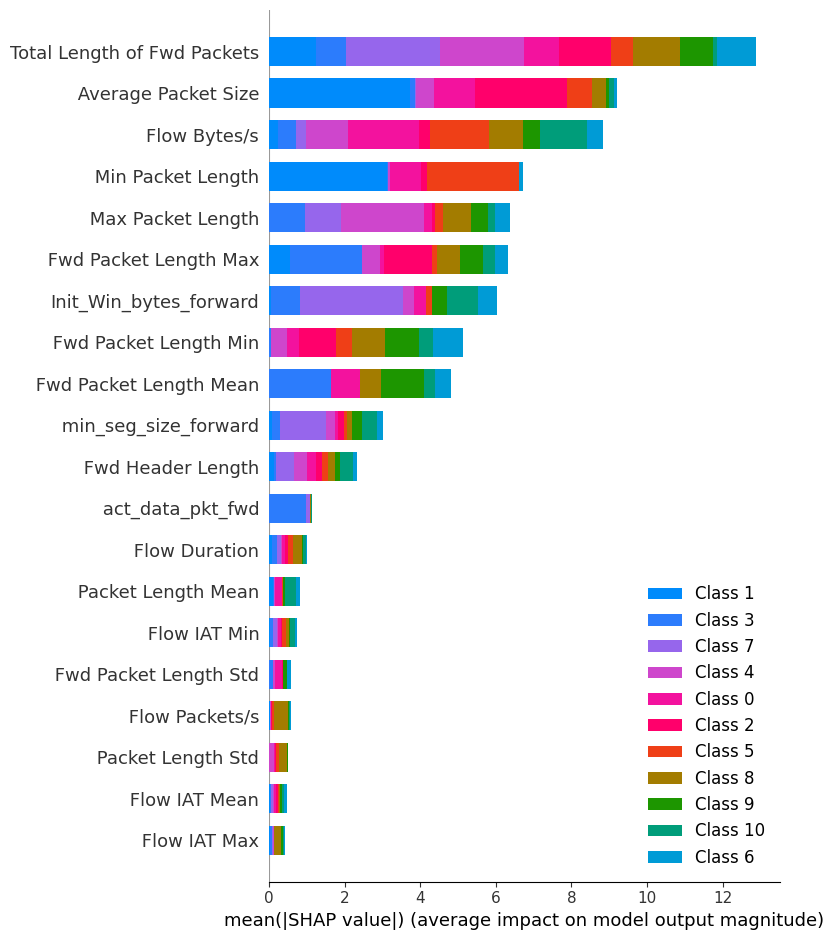

In [20]:
#shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= multiclass_labels, feature_names = X.columns)
shap.summary_plot(shap_values, X)

In [24]:


xg_feat = ['Total Length of Fwd Packets',' Average Packet Size','Flow Bytes/s',' Min Packet Length', ' Max Packet Length',' Fwd Packet Length Max','Init_Win_bytes_forward',' Fwd Packet Length Min',' Fwd Packet Length Mean',' min_seg_size_forward',' Fwd Header Length',' act_data_pkt_fwd',' Flow Duration',' Packet Length Mean',]


kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


for train_index, test_index in kf.split(X, y):

    current_X = X.loc[:, xg_feat]

    X_train, X_test = current_X.iloc[train_index,:], current_X.iloc[test_index,:]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]

    xgs = xgb.XGBClassifier(random_state=42)
    xgs.fit(X_train,Y_train)

    predicted_values = xgs.predict(X_test)

    print(classification_report(Y_test, predicted_values, target_names=multiclass_labels, digits=6))


              precision    recall  f1-score   support

         DNS   0.764714  0.507007  0.609749     10917
        LDAP   0.585337  0.633382  0.608413     10916
       MSSQL   0.928871  0.953463  0.941006     10916
         NTP   0.993801  0.998626  0.996207     10916
     NetBIOS   0.954481  0.987358  0.970641     10916
        SNMP   0.685625  0.841440  0.755583     10917
        SSDP   0.509859  0.528215  0.518875     10916
         Syn   0.599656  0.991389  0.747298     10916
        TFTP   0.998250  0.993038  0.995637     10916
         UDP   0.523195  0.531055  0.527096     10916
     UDP-lag   0.849129  0.223230  0.353521     10917

    accuracy                       0.744377    120079
   macro avg   0.762993  0.744382  0.729457    120079
weighted avg   0.762993  0.744377  0.729453    120079

              precision    recall  f1-score   support

         DNS   0.758506  0.502382  0.604431     10916
        LDAP   0.581617  0.631217  0.605403     10917
       MSSQL   0.930651 

In [12]:
params = []
#estimators = []
# This will hold all of our results.
runFrame = None

for name, model in models.items():
        for feature_key, feature_val in feature_set.items():

            # If we're on the RFE sets, check if we have one for this classifier. If not, skip it.
            if feature_key == "RFE Sets":
                if name in feature_val.keys():
                    feature_val = feature_val[name]
                else:
                    continue
            
            for score_method in score_methods:
                opt = BayesSearchCV(estimator=model,search_spaces=search_spaces[name],n_iter=50,scoring=score_method,cv=5,n_jobs=5)
                kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

                counter = 0

                # Used to hold data for a single run (performance metric)
                perfFrame = None

                for train_index, test_index in kf.split(X, y):

                    counter += 1

                    # PCA requires different logic to create X.
                    if feature_key != "PCA":
                        current_X = X.loc[:, feature_val]
                        X_train, X_test = current_X.iloc[train_index,:], current_X.iloc[test_index,:]
                        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
                        
                    else:
                        pca_trans = PCA(n_components=feature_val, random_state=42)
                        current_X = X.loc[:, X.columns]
                        X_train, X_test = current_X.iloc[train_index,:], current_X.iloc[test_index,:]
                        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]

                        # Apply PCA to training set and use it to transform test set.
                        X_train = pca_trans.fit_transform(X_train)
                        X_test = pca_trans.transform(X_test)

                        # Convert back to DataFrames
                        pca_cols = ["PC"+str(i) for i in list(range(1, len(X_train[0])+1))]
                        X_train = pd.DataFrame(data=X_train, columns=pca_cols)
                        X_test = pd.DataFrame(data=X_test, columns=pca_cols)

                    startTime = time()

                    opt.fit(X_train,Y_train)

                    endTime = time()
                    fitTime = endTime - startTime

                    predicted_values = opt.predict(X_test)

                    # get metrics for this fold.
                    foldFrame = format_results_multiclass(Y_test, predicted_values, counter, fitTime)

                    # Add them to our lists of metric.
                    if perfFrame is None:
                        perfFrame = foldFrame
                    else:
                        perfFrame = pd.concat([perfFrame, foldFrame])

                    # Print a classification report as well.
                    print(classification_report(Y_test, predicted_values, target_names=multiclass_labels, digits=6))

                    # Add tuple with the best params as well as the related model/config
                    params.append((f"Multiclass {name} {feature_key} {score_method} Fold {counter}", opt.best_params_))
                    #estimators.append((f"Multiclass {name} {feature_key} {score_method} Fold {counter}", opt.best_estimator_))

                # Create a new line in the results table that averages all the folds
                perfFrame.loc["fold average"] = perfFrame.mean()

                # Mark the results table with the chosen classifier and the current performance metric.
                perfFrame['metric'] = [score_method for j in range(0,6)]
                perfFrame['Classifier'] = [name for j in range(0,6)]
                perfFrame['Feature Set'] = [feature_key for j in range(0,6)]
                perfFrame['Dataset'] = ["multiclass" for j in range(0,6)]
                print(f"{name} with {feature_key} and {score_method} completed.")

                # Add this run to the table with all runs.
                if runFrame is None:
                    runFrame = perfFrame
                else:
                    runFrame = pd.concat([runFrame, perfFrame])

# Write output file, best parameters, and best models to be used later.
runFrame.to_csv(f"multiclass_results{time()}.csv")
pickle.dump(params, open(f"multiclass_params{time()}.pickle", "wb"))
#pickle.dump(estimators, open(f"multiclass_estimators{time()}.pickle", "wb"))

c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

         DNS   0.743430  0.502702  0.599814     10917
        LDAP   0.579027  0.629260  0.603099     10916
       MSSQL   0.924846  0.950348  0.937424     10916
         NTP   0.993335  0.996702  0.995016     10916
     NetBIOS   0.953845  0.986350  0.969825     10916
        SNMP   0.684661  0.827150  0.749191     10917
        SSDP   0.498920  0.444485  0.470132     10916
         Syn   0.599956  0.988366  0.746669     10916
        TFTP   0.998158  0.992671  0.995407     10916
         UDP   0.509311  0.573745  0.539611     10916
     UDP-lag   0.790740  0.240909  0.369304     10917

    accuracy                       0.739330    120079
   macro avg   0.752384  0.739335  0.725045    120079
weighted avg   0.752384  0.739330  0.725041    120079



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

         DNS   0.739440  0.503573  0.599128     10916
        LDAP   0.577339  0.626363  0.600852     10917
       MSSQL   0.933194  0.943111  0.938126     10916
         NTP   0.993341  0.997527  0.995429     10916
     NetBIOS   0.956046  0.984335  0.969984     10916
        SNMP   0.678746  0.827043  0.745592     10916
        SSDP   0.499488  0.446734  0.471641     10917
         Syn   0.597303  0.982136  0.742837     10916
        TFTP   0.996962  0.992213  0.994582     10916
         UDP   0.510824  0.568523  0.538131     10916
     UDP-lag   0.768079  0.249084  0.376176     10916

    accuracy                       0.738237    120078
   macro avg   0.750069  0.738240  0.724771    120078
weighted avg   0.750066  0.738237  0.724768    120078

              precision    recall  f1-score   support

         DNS   0.750000  0.513100  0.609334     10916
        LDAP   0.583838  0.618175  0.600516     10916
       MSSQL   0.922562 

c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

         DNS   0.738619  0.500916  0.596976     10916
        LDAP   0.576979  0.623065  0.599137     10917
       MSSQL   0.931112  0.947233  0.939104     10916
         NTP   0.993251  0.997710  0.995476     10916
     NetBIOS   0.956808  0.984243  0.970332     10916
        SNMP   0.679367  0.829791  0.747082     10916
        SSDP   0.500923  0.397912  0.443514     10917
         Syn   0.596271  0.987266  0.743498     10916
        TFTP   0.997329  0.992122  0.994719     10916
         UDP   0.507873  0.617534  0.557361     10916
     UDP-lag   0.782583  0.242030  0.369717     10916

    accuracy                       0.738162    120078
   macro avg   0.751010  0.738166  0.723356    120078
weighted avg   0.751007  0.738162  0.723353    120078

              precision    recall  f1-score   support

         DNS   0.748005  0.515299  0.610219     10916
        LDAP   0.583118  0.620191  0.601083     10916
       MSSQL   0.924298 

c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


              precision    recall  f1-score   support

         DNS   0.692218  0.490564  0.574201     10916
        LDAP   0.568118  0.595181  0.581335     10916
       MSSQL   0.898887  0.917827  0.908259     10916
         NTP   0.900460  0.932301  0.916104     10916
     NetBIOS   0.951274  0.978199  0.964549     10917
        SNMP   0.667316  0.815317  0.733930     10916
        SSDP   0.495329  0.500275  0.497790     10916
         Syn   0.595354  0.993130  0.744438     10917
        TFTP   0.993640  0.987541  0.990581     10916
         UDP   0.513654  0.532429  0.522873     10916
     UDP-lag   0.892585  0.204012  0.332115     10916

    accuracy                       0.722439    120078
   macro avg   0.742622  0.722434  0.706016    120078
weighted avg   0.742622  0.722439  0.706018    120078

              precision    recall  f1-score   support

         DNS   0.597521  0.631458  0.614021     10916
        LDAP   0.592507  0.423049  0.493640     10916
       MSSQL   0.903013 